## Notebook to accompany `RNN for TimeSeries.pdf` lecture

- Auto-correlation: Correlograms
- Stationarity
- Decomposition
- Windowing (recap)

Bonus (if time permits):
- ARIMA

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# may need to install
# pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

sns.set_style('whitegrid')

%matplotlib inline

## Start of Lecture

Read data

In [2]:
# parse dates and set the date column as index
df = pd.read_csv('./exchange-rates-sgd-per-unit-of-usd-average-for-period-annual/exchange-rates-sgd-per-unit-of-usd-daily.csv',
                 parse_dates=True, index_col=0)
df.head()

,exchange_rate_usd
date,
1988-01-08,2.0443
1988-01-15,2.0313
1988-01-22,2.0205
1988-01-29,2.0182
1988-02-05,2.0160


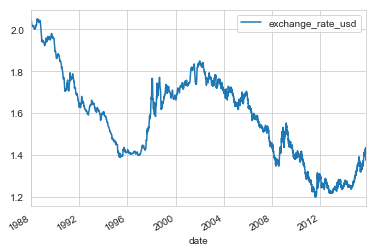

In [34]:
df.plot()
#df.iloc[1000:1401].plot()
plt.show()

### Auto-correlation: Correlograms

In [8]:
import statsmodels
statsmodels.__version__

'0.9.0'

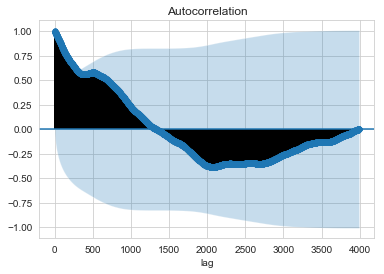

In [55]:
plot_acf(df, lags=3992) # statsmodels 0.10.0 may not show all lags
ax = plt.gca()
ax.set_xlabel('lag')
plt.show()

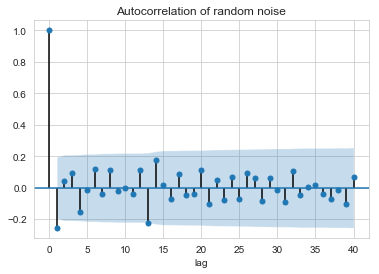

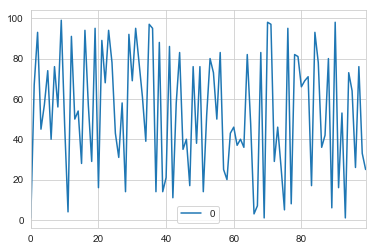

In [41]:
import numpy as np
random_df = pd.DataFrame(np.random.randint(0, 100, size=(100, 1)))

plot_acf(random_df, lags=99)
ax = plt.gca()
ax.set_title('Autocorrelation of random noise')
ax.set_xlabel('lag')
plt.show()

random_df.plot()
plt.show()

### Stationarity

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

https://machinelearningmastery.com/time-series-data-stationary-python/

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [54]:
from statsmodels.tsa.stattools import adfuller

# p value > 0.05 (0.05751995237318788)
# null hypothesis is not rejected => non-stationary

adfuller(df['exchange_rate_usd'])

(-2.805305147317009,
 0.05751995237318788,
 24,
 3968,
 {'1%': -3.431999076458594,
  '5%': -2.862268671768981,
  '10%': -2.5671578800184744},
 -28503.951931643587)

In [50]:
# p value < 0.05 (2.8848649024532495e-24)
# reject the null hypothesis => stationary 

adfuller(random_df[0])

(-12.985441617218136,
 2.8848649024532495e-24,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 835.6292892108518)

In [56]:
# computes the difference = y[t+1]-y[t]
df['exchange_rate_usd'].diff()

date
1988-01-08       NaN
1988-01-15   -0.0130
1988-01-22   -0.0108
1988-01-29   -0.0023
1988-02-05   -0.0022
1988-02-12    0.0013
1988-02-19    0.0016
1988-02-26   -0.0059
1988-03-04    0.0024
1988-03-11   -0.0023
1988-03-18    0.0053
1988-03-25   -0.0052
1988-03-31   -0.0087
1988-04-08   -0.0015
1988-04-15   -0.0011
1988-04-22    0.0018
1988-04-29   -0.0021
1988-05-06    0.0023
1988-05-13    0.0013
1988-05-20    0.0076
1988-05-27    0.0040
1988-06-03    0.0049
1988-06-10   -0.0037
1988-06-17    0.0066
1988-06-24    0.0100
1988-07-01    0.0137
1988-07-08   -0.0040
1988-07-15    0.0060
1988-07-22   -0.0119
1988-07-29   -0.0006
               ...  
2015-09-04    0.0020
2015-09-07    0.0066
2015-09-08    0.0013
2015-09-09   -0.0122
2015-09-10    0.0072
2015-09-14   -0.0108
2015-09-15   -0.0093
2015-09-16   -0.0003
2015-09-17   -0.0020
2015-09-18    0.0015
2015-09-21    0.0047
2015-09-22    0.0078
2015-09-23    0.0091
2015-09-25    0.0024
2015-09-28    0.0016
2015-09-29    0.0060
2015-09-

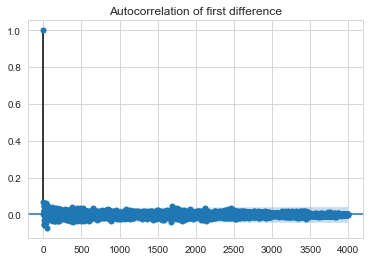

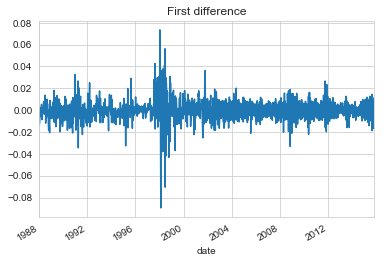

(-13.666790372071787,
 1.4854573152309832e-25,
 23,
 3968,
 {'1%': -3.431999076458594,
  '5%': -2.862268671768981,
  '10%': -2.5671578800184744},
 -28489.799150961888)

In [60]:
diff = df['exchange_rate_usd'].diff()

diff.dropna(inplace=True) # drop the first NaN

# Auto-correlation plot
plot_acf(diff)
ax = plt.gca() # get current axis
ax.set_title('Autocorrelation of first difference')
plt.show()

diff.plot()
ax = plt.gca()
ax.set_title('First difference')
plt.show()

# adfuller
adfuller(diff) # pvalue < 0.05 (1.4854573152309832e-25), stationary

#### Handling Stationarity

Typically:
1. Run adfuller on the raw time series
2. If pvalue < 0.05, then it's stationary (no action)
3. If pvalue > 0.05, then consider taking the difference before continuing


### Decomposition

In [93]:
# series was weekly, then daily
df

,exchange_rate_usd
date,
1988-01-08,2.0443
1988-01-15,2.0313
1988-01-22,2.0205
1988-01-29,2.0182
1988-02-05,2.0160
1988-02-12,2.0173
1988-02-19,2.0189
1988-02-26,2.0130
1988-03-04,2.0154


In [91]:
# freq is a number indicating weekly, daily, monthly, annually
# (poorly documented)
# https://github.com/statsmodels/statsmodels/issues/3085

additive = seasonal_decompose(df, freq=52)

In [96]:
df.describe()

,exchange_rate_usd
count,3993.000000
mean,1.494808
std,0.197901
min,1.200900
25%,1.303300
50%,1.462200
75%,1.669100
max,2.050300


In [95]:
# look at statistics of the component to see if it is significant
# in this case, the seasonal part is not significant
# std of seasonal component = 0.001799
# std of original data = 0.197901
additive.seasonal.describe()

,exchange_rate_usd
count,3993.000000
mean,0.000007
std,0.001799
min,-0.003387
25%,-0.001766
50%,0.000608
75%,0.001450
max,0.003234


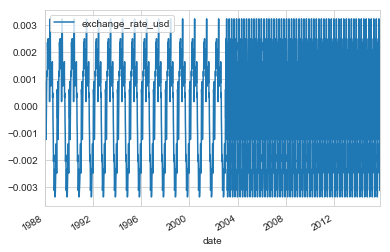

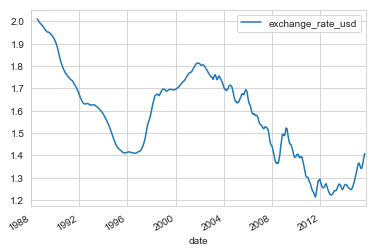

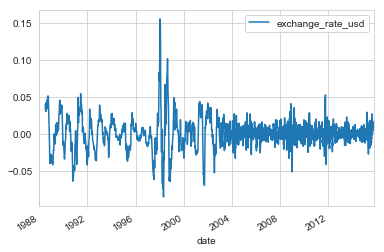

In [92]:
additive.seasonal.plot() # seasonal component
plt.show()
additive.trend.plot() # trend component
plt.show()
additive.resid.plot() # resdual component
plt.show()

In [98]:
multiplicative = seasonal_decompose(df, model='mult', freq=52)

In [99]:
multiplicative.seasonal.describe()

,exchange_rate_usd
count,3993.000000
mean,1.000004
std,0.001167
min,0.997778
25%,0.998880
50%,1.000424
75%,1.000931
max,1.002006


### How to handle seasonality
- If you see some kind of cycle in your data, try seasonal_decompose to see how large the seasonal component is
- If std(seasonal) similar magnitude as std(raw data), then you should proceed modeling using RNN without seasonal component.
- Else, you can use RNN as before
- Alternatively, you can use statistical method like SARIMA, SARIMAX to forecast.

### Windowing (recap)

#### Helper function for windowing

In [ ]:
def sequence_to_supervised_learning(series, colname, window_size, dropna=True):
    """Transforms a sequence into a supervised
    learning dataset
    
    Inputs:
        series - the input sequence as a pd.DataFrame
        colname - name of the column to use
        window_size - the window sizes to create
        dropna - whether to drop NaN rows
    Output:
        a supervised learning dataset, of window size as features
        and the current value as the target
    """
    shifted = [series.shift(-i) for i in range(window_size)]
    colnames = [f'{colname}[t+{i}]' for i in range(window_size)]
    
    result = pd.concat(shifted, axis=1)
    result.columns = colnames

    if dropna:
        # last window_size rows will have missing values because
        # they are shifted into the future
        result.dropna(inplace=True)
    return result

### Bonus (if time permits): ARIMA

(This is a statistical method, not machine learning)

In [128]:
p = 3 # AR lag 3
d = 2 # difference 2
q = 2 # MA lag 2
model = ARIMA(df['exchange_rate_usd'], (p, d, q)).fit()
print(model.aic, model.bic) # metrics

# -28681.801391202287 -28637.755304452843

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  range_index):
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  range_index):


-28652.646720972334 -28608.604141236992


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  Hinv = np.asfortranarray((Hinv + Hinv.T) / 2.0)


In [129]:
model.params

const                         3.934777e-07
ar.L1.D2.exchange_rate_usd   -8.287023e-01
ar.L2.D2.exchange_rate_usd    7.147657e-02
ar.L3.D2.exchange_rate_usd    6.494128e-02
ma.L1.D2.exchange_rate_usd   -1.732755e-01
ma.L2.D2.exchange_rate_usd   -8.190819e-01
dtype: float64

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  raise KeyError('The `end` argument could not be matched to a'
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  raise KeyError('The `end` argument could not be matched to a'
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  raise KeyError('The `end` argument could not be matched to a'


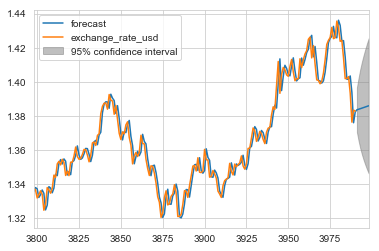

In [130]:
# predict future values (end is in the future)
model.plot_predict(start=3800, end=4000)
plt.show()

### Notes

- Note that ARIMA is only for forecasting. It is a statistical method.
- ARIMA does not account for seasonality. So if you have seasonal time series, consider SARIMAX
- ARIMA tuning: use pyramid.arima.auto_arima to find best p, d, q.
- ARIMA can be quite slow to run.


- If using RNN for non-forecasting (e.g. predicting an activity from sensor data), you should not need to worry about stationarity, seasonality.